&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&ensp;
[Home Page](../Start_Here.ipynb)

[Previous Notebook](Start_Here.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](Start_Here.ipynb)
[2]
[3](Part3.ipynb)
[4](Part4.ipynb)
[5](Competition.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next Notebook](Part3.ipynb)





# Steady State Flow Using Neural Networks - Part 2 

**Contents of this notebook:**

- [Approaching the Problem](#Approaching-the-Problem)
- [Data and Task](#Data-and-Task)
- [Model and Loss](#Model-and-Loss) 
- [Training and Evaluation](#Training-and-Evaluation) 
- [Building our First Model](#Building-our-First-Model)


**By the End of this Notebook you will:**

- Understand the working pipeline of DL Network.
- Building our first model using Fully Connected networks.

# Approaching the Problem

####  As mentioned in the Introduction to Deep Learning notebook we will follow the same steps in this notebook as well:
 
- Data
- Tasks
- Model
- Loss
- Learning
- Evaluation

# Data and Task 

Like we saw in the previous notebook, our input and output data are as follows :

<img src="images/flow_example.png">

This Simulated Flow lines were calculated using Lattice Boltzmann method ([Mechsys](http://mechsys.nongnu.org/)). 

Let us import our dataset and see some of the input output pairs : 

In [1]:
# Importing Necessary Libaries 
from __future__ import print_function

import sys
sys.path.append('/workspace/python/source_code')

import numpy as np
import utils.data_utils as data_utils
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import math
import matplotlib.pyplot as plt

import time

import importlib
# reload(data_utils) # you need to execute this in case you modify the plotting scripts in data_utils

The input dataset is stored as a `TFRecords` file which is suitable for storing large datasets which cannot be loaded into memory and Tensorflow takes batches of data to optimize our data pipelining process.

In [2]:
# Set up our dataset
dataset = tf.data.TFRecordDataset('data/train.tfrecords')
# Transform binary data into image arrays
dataset = dataset.map(data_utils.parse_flow_data) 

batched_dataset = dataset.batch(32, drop_remainder=True)

# Create an iterator for reading a batch of input and output data
iterator = iter(batched_dataset)
boundary, vflow = next(iterator)

print('Input shape:', boundary.shape.as_list())
print('Output shape:', vflow.shape.as_list())

Input shape: [32, 128, 256, 1]
Output shape: [32, 128, 256, 2]


We have set up a batch of 32 images with 128x256 resolution. The input data has only 1 channel (last dimension), which describes the boundary. The output data has 2 channels the x and y velocity component of the flow.

Let us now display some of the training examples. Feel free to change `plot_idx`, and try plotting into a single figure.

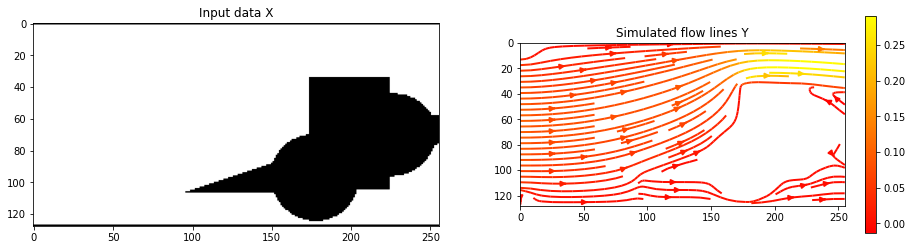

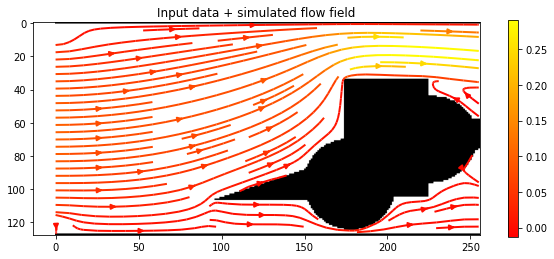

In [3]:
plot_idx = 10 # set it between 0-31

data_utils.plot_flow_data(boundary[plot_idx,:,:,:], vflow[plot_idx,:,:,:])

# You can plot the input and output data into a single figure
data_utils.plot_flow_data(boundary[plot_idx,:,:,:], vflow[plot_idx,:,:,:], single_plot=True)

    

In [4]:
# How a Boundary is defined ?  

# Running counter over the Input 
from collections import Counter
c = np.array(boundary[plot_idx,:,:,:]).flatten()
c = Counter(c)
c

Counter({1.0: 7390, 0.0: 25378})

From the Input data, we can notice the boundary is defined by 1's and 0's, which is also reported to us by the counter above.

Let us now understand how the flow lines are described.

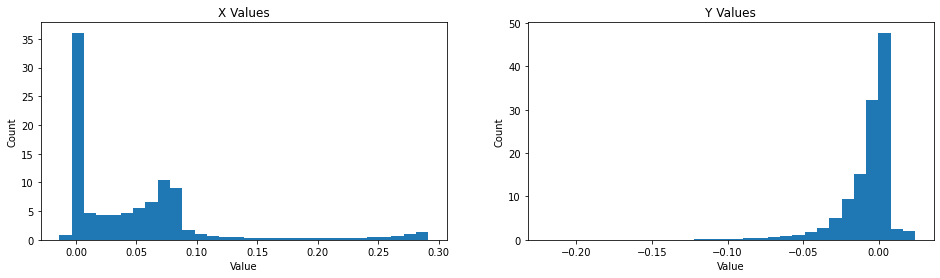

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 4))

ax1.hist(np.array(vflow[plot_idx,:,:,0]).flatten(), density=True, bins=30)
ax1.set_ylabel('Count')
ax1.set_xlabel('Value')
ax1.set_title("X Values")


ax2.hist(np.array(vflow[plot_idx,:,:,1]).flatten(), density=True, bins=30)
ax2.set_ylabel('Count')
ax2.set_xlabel('Value')
ax2.set_title("Y Values")
plt.show()

From the X and Y Values, we can observe that each pixel denotes the velocity vector corresponding to that pixel :

Positive meaning $+x$ or $+y $ direction and negative meaning the $-x$ or $-y $ direction respectively.

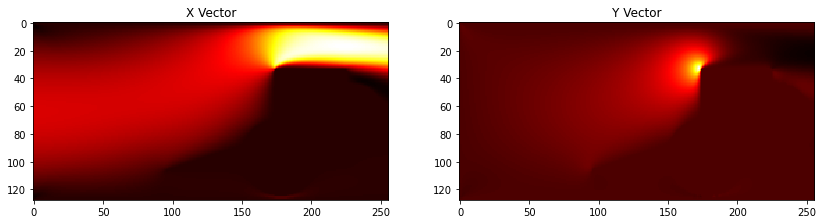

In [6]:
#Plotting Heatmap of the 2-Channels
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 14))

# Plotting X vector and Y vector separately.

# X Vector 

ax1.imshow(vflow[plot_idx,:,:,0], cmap='hot', interpolation='nearest')
ax1.set_title("X Vector")

# Y Vector

ax2.imshow(-vflow[plot_idx,:,:,1], cmap='hot', interpolation='nearest')
ax2.set_title("Y Vector")
plt.show()

Now that we understand our input and output data, our task is now to predict the velocity vectors of both the $x$ and $y$ channels from our model.

Let us now split the dataset into Training, Test and Validation Data.

# Model and Loss

We will be building the following Models and benchmarking them as we proceed :

* Simple Fully Connected Networks 
    - *3 Layer Network*
    - *5 Layer Network*
* Convolution Neural Networks 
    - *Binary Boundary*
    - *Signed Distance Function*
* Advanced Networks
    - *Gated Residual Network*
    - *Non-Gated Residual Network*
    
    
There are a variety of functions also discussed in the *Introduction to Deep Learning Notebook*. In this *Task*, we will be using Squared Error Loss.

$$ \mathrm{Loss}(\hat{v}_x, \hat{v}_y, v_x, v_y) = \sum_{i=1}^{n_\mathrm{batch}} 
  \sum_{x=1,y=1}^{nh,nw} \left(\left(v_x^i(x,y) - \hat{v}_x^i(x,y)\right)^2 + 
   \left(v_y^i(x,y) - \hat{v}_y^i(x,y)\right)^2\right) . $$
  
This can be implemented easily using [tf.nn.l2_loss](https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss).

# Training and Evaluation

* Epochs: We will be using 25 - 30 epochs. Readers are free to change and play with the values. 
* Activation Function: We will start with ReLu and improving upon same
* Optimizer: We will be using Adam Optimizer with Learning Rate of 0.0001
* Test Set: We will be using a set of 28 boundary conditions as part of the out Test set.

Now we have an idea on how to proceed. Let us start building our First Fully Connected Model.

# Building our First Model

### Let's import our data and divide them into training, test and validation sets

In [7]:
batch_size = 8
dataset_size = 3000   # Number of elements in the train.tfrecords
validation_size = 256 # Number of elements to use for validation

# derive some quantities
train_size = dataset_size - validation_size
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

test_size = 28
test_batches = int(test_size/batch_size)
print('Number of batches in train/validation/test dataset:', train_batches, '/', validation_batches, '/', test_batches)

def init_datasets():
    dataset = tf.data.TFRecordDataset('data/train.tfrecords')
    # Transform binary data into image arrays
    dataset = dataset.map(data_utils.parse_flow_data)
    
    training_dataset = dataset.skip(validation_size).shuffle(buffer_size=512)
    training_dataset = training_dataset.batch(batch_size, drop_remainder=True)
    training_dataset = training_dataset.repeat()

    validation_dataset = dataset.take(validation_size).batch(batch_size, drop_remainder=True)
    validation_dataset = validation_dataset.repeat()

    # Read test dataset
    test_dataset = tf.data.TFRecordDataset('data/test.tfrecords')
    test_dataset = test_dataset.map(data_utils.parse_flow_data) # Transform binary data into image arrays
    test_dataset = test_dataset.batch(batch_size, drop_remainder = True).repeat()
 
    return training_dataset, validation_dataset, test_dataset

training_dataset, validation_dataset, test_dataset = init_datasets()

Number of batches in train/validation/test dataset: 343 / 32 / 3


### Loss function 

Now let us define  Loss Function using [tf.nn.l2_loss](https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss)

In [8]:
def loss_image(vflow_hat, vflow):
    '''Defines the loss for the predicted flow.
    
    Arguments:
    vflow_hat -- predicted flow, shape (?, nh, nw, 2)
    vflow   -- target flow from the simulation, shape (?, nh, nw, 2)
    
    Returns: the L2 loss
    ''' 
    ### Define the square error loss (~ 1 line of code)
    loss = tf.nn.l2_loss(vflow_hat - vflow)
    ###
                         
    # Add a scalar to tensorboard
    tf.summary.scalar('loss', loss)
    
    return loss

### Model 

3 - Layer Fully Connected Network : 

* Input Layer of Size ( 128 * 256 * 1 )
* Hidden Layer of Size ( 256 ) 
* Output Layer of Size ( 128 * 256 * 2 ) 


In [9]:
def fully_connected(input):
    # Arguments:
    # input -- input layer for the network, expected shape (?,nh,nw,1)
    # Returns -- predicted flow (?, nh, nw, 2)
    
    nh = K.int_shape(input)[1]
    nw = K.int_shape(input)[2]
    
    # define the hidden layer
    x = layers.Flatten()(input)
    x = layers.Dense(256, activation='relu')(x)
    
    
    ### Define output layer and reshape it to nh x nw x 2. 
    ### (Note that the extra batch dimension is handled automatically by Keras)
    x = layers.Dense(nh*nw*2, activation='relu')(x)
    output = layers.Reshape((nh,nw,2))(x)
    ###
    
    return output

Let us define the input and parameters of our model : 

In [10]:
# Define Inputs and Outputs
input = tf.keras.Input(shape=(128,256,1))
output = fully_connected(input)
# Use Keras Functional API to Create our Model and Define our Optimizer and Loss Function
fc_model = tf.keras.Model(inputs = input, outputs=output)
fc_model.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
fc_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 256, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             16842752  
_________________________________________________________________
reshape (Reshape)            (None, 128, 256, 2)       0         
Total params: 25,231,616
Trainable params: 25,231,616
Non-trainable params: 0
_________________________________________________________________


### Let us now train our Model : 

In [11]:
history = fc_model.fit(training_dataset, epochs=30, steps_per_epoch=train_batches,
          validation_data=validation_dataset, validation_steps=validation_batches)

Train for 343 steps, validate for 32 steps
Epoch 1/30
343/343 [==============================] - 4s 11ms/step - loss: 283.8151 - val_loss: 201.4778
Epoch 2/30
343/343 [==============================] - 3s 7ms/step - loss: 178.8010 - val_loss: 176.0509
Epoch 3/30
343/343 [==============================] - 3s 7ms/step - loss: 161.6991 - val_loss: 159.7302
Epoch 4/30
343/343 [==============================] - 3s 7ms/step - loss: 151.6684 - val_loss: 155.4359
Epoch 5/30
343/343 [==============================] - 3s 8ms/step - loss: 146.8477 - val_loss: 151.7460
Epoch 6/30
343/343 [==============================] - 2s 7ms/step - loss: 140.3008 - val_loss: 147.7243
Epoch 7/30
343/343 [==============================] - 3s 7ms/step - loss: 136.5533 - val_loss: 142.1309
Epoch 8/30
343/343 [==============================] - 2s 7ms/step - loss: 134.0691 - val_loss: 143.6562
Epoch 9/30
343/343 [==============================] - 3s 7ms/step - loss: 131.7504 - val_loss: 155.3597
Epoch 10/30
343/343 

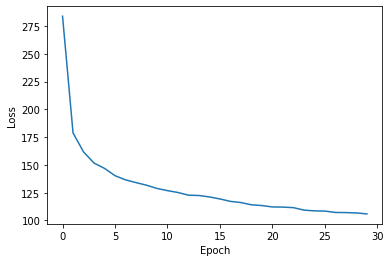

In [12]:
# Let us Plot the train History
data_utils.plot_keras_loss(history)

### Test

We will evaluate the model on the test dataset, and plot some of the results.

In [13]:
test_loss = fc_model.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 7ms/step - loss: 101.2483
The loss over the test dataset 101.248291015625


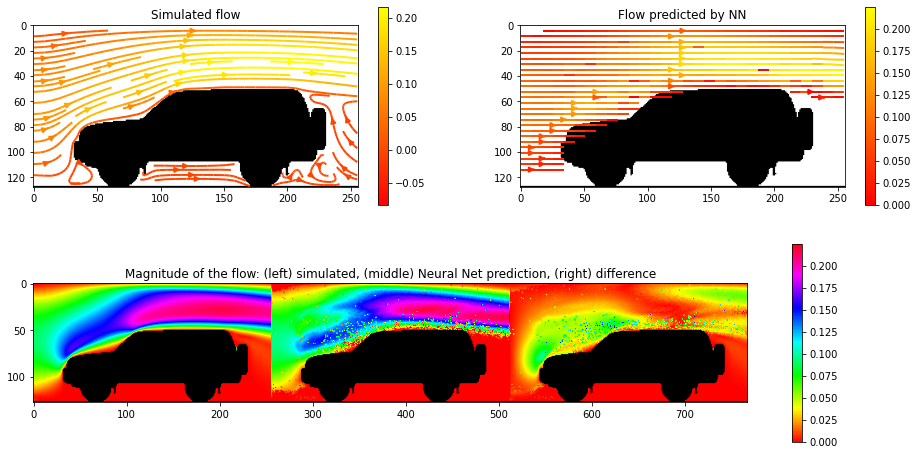

In [14]:
x, vxy = data_utils.load_test_data(1) # you can try different numbers between 1 and 28
vxy_hat = fc_model.predict(x)
data_utils.plot_test_result(x, vxy, vxy_hat)

We can plot a vertical slice of the velocity field for better comparison

Text(0, 0.5, 'vy')

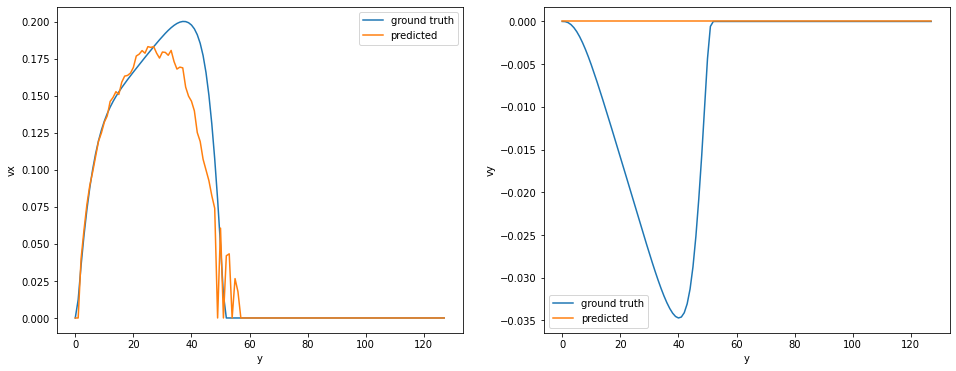

In [15]:
x_idx=120 # x coordinate for the slice

vx = np.squeeze(vxy[0,:,x_idx,0])                 # test velocity fields
vy = np.squeeze(vxy[0,:,x_idx,1])

vx_hat = np.squeeze(vxy_hat[0,:,x_idx,0])         # predicted velocity field
vy_hat = np.squeeze(vxy_hat[0,:,x_idx,1])

fig = plt.figure(figsize=(16,6))

# plot the x component of the velocity
ax = fig.add_subplot(121)
ax.plot(vx, label='ground truth')
ax.plot(vx_hat, label='predicted')
ax.legend()
ax.set_xlabel('y')
ax.set_ylabel('vx')

# plot the y component of the velocity
ax = fig.add_subplot(122)
ax.plot(vy, label='ground truth')
ax.plot(vy_hat, label='predicted')
ax.legend()
ax.set_xlabel('y')
ax.set_ylabel('vy')


In the upcoming notebook let us define a 5 Layer fully connected network and train it.

## Important:
<mark>Shutdown the kernel before clicking on “Next Notebook” to free up the GPU memory.</mark>


## Licensing
This material is released by NVIDIA Corporation under the Creative Commons Attribution 4.0 International (CC BY 4.0)

[Previous Notebook](Start_Here.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](Start_Here.ipynb)
[2]
[3](Part3.ipynb)
[4](Part4.ipynb)
[5](Competition.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next Notebook](Part3.ipynb)

&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&ensp;
[Home Page](../Start_Here.ipynb)